In [1]:
import os

datadir = '../data/XY-model/'
os.makedirs(datadir, exist_ok=True)

In [16]:
import netket as nk
from netket.graph import Lattice
from netket.operator.spin import sigmax, sigmay, sigmaz
import json
import jax.numpy as jnp
import numpy as np
def get_XYZ_Hamiltonian(Jxx, Jyy, Jzz, Lx, Ly):
    """
    Constructs the XYZ model Hamiltonian on a square lattice with periodic boundary conditions.

    H = -sum_{<i,j>} (Jxx S^x_i S^x_j + Jyy S^y_i S^y_j + Jzz S^z_i S^z_j)

    Args:
        Jxx: Coupling constant for x-direction
        Jyy: Coupling constant for y-direction
        Jzz: Coupling constant for z-direction
        Lx: Number of sites along x
        Ly: Number of sites along y

    Returns:
        g: NetKet Lattice object
        hi: NetKet Hilbert space
        H: NetKet Hamiltonian operator
    """
    g = Lattice(basis_vectors=[[1, 0], [0, 1]], pbc=False, extent=[Lx, Ly])
    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    H = 0
    for (i,j) in g.edges():
        # Right neighbor
        H += -Jxx * sigmax(hi, i) * sigmax(hi, j) + Jyy * sigmay(hi, i) * sigmay(hi, j) + Jzz * sigmaz(hi, i) * sigmaz(hi, j)
    return g, hi, H

In [17]:
Lx = 3
Ly = 3
n_samples = 300
vmc_steps = 1000
learning_rate = 0.002
diag_shift = 1e-4
# diag_shift = 1e-1

In [18]:
g, hi, H = get_XYZ_Hamiltonian(1.0,1.0,0.0, Lx, Ly)
import optimization

params = optimization.generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-3,
    n_iter=2000,
    show_progress=True,
    diag_shift=1e-4,
    Lx = Lx,
    Ly = Ly,
    Jxx = 1.0,
    Jyy = 1.0,
    Jzz = 0.0,
    out=f"../data/XY-model/rbm_optimization",
)
output_file = params["out"] + ".log"
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:

    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
g, hi, H = get_XYZ_Hamiltonian(1.0,0.0,1.0, Lx, Ly)
import optimization

params = optimization.generate_params(
    alpha=1,
    seed=1234,
    learning_rate=3e-3,
    n_iter=2000,
    show_progress=True,
    diag_shift=1e-4,
    Lx = Lx,
    Ly = Ly,
    Jxx = 1.0,
    Jyy = 0.0,
    Jzz = 1.0,
    out=f"../data/XY-model/rbm_optimization",
)
output_file = params["out"] + ".log"
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:

    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


  0%|          | 0/2000 [00:00<?, ?it/s]

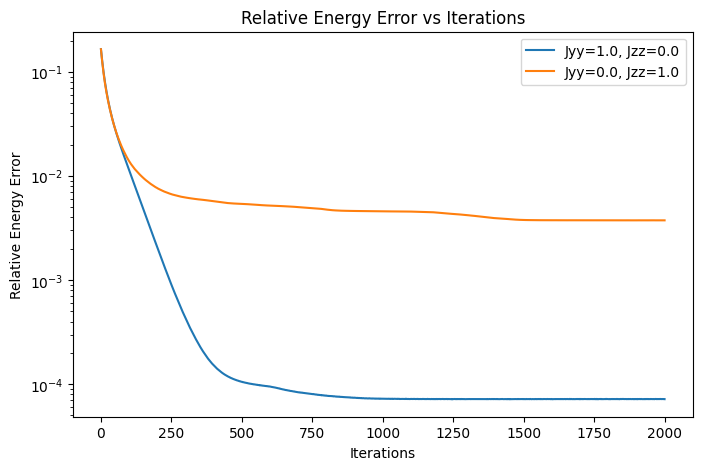

In [21]:
import h5py
import matplotlib.pyplot as plt
h5_files = [os.path.join("../data/XY-model", f) for f in os.listdir('../data/XY-model') if f.endswith('.h5')]
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
# Open the HDF5 file
ed_energy = 0
for file in h5_files:
    with h5py.File(file, "r") as f:
        energy = f["en_var_steps"][:]
        e0 = f["exact_ground_energy"][()]
        ed_energy = e0
        Jyy = f.attrs["Jyy"]
        Jzz = f.attrs["Jzz"]
        relative_energy_error = (energy - e0) / abs(e0)

        # Plot the relative energy error
        ax.plot(range(len(relative_energy_error)), relative_energy_error, linestyle='-', label='Jyy={:.1f}, Jzz={:.1f}'.format(Jyy, Jzz))

plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Relative Energy Error")
plt.title("Relative Energy Error vs Iterations")
plt.legend()
        # plt.grid(True)
plt.show()

[-14.37497217 -12.84903632 -14.37497217 -12.84903632 -10.84175721]
[-14.37497217 -12.84903632 -14.37497217 -12.84903632 -10.84175721]


<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3634756/2985205994.py:23: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c='black', linewidth=1,label = f"XZ: $\delta E= {E_RBM_XZ:.4f}$")
/tmp/ipykernel_3634756/2985205994.py:26: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c='black', linewidth=1,linestyle='--',label = f"XY: $\delta E= {E_RBM_XY:.4f}$")


Text(0.5, 1.0, 'Ground State Probability Distribution (colored by phase)')

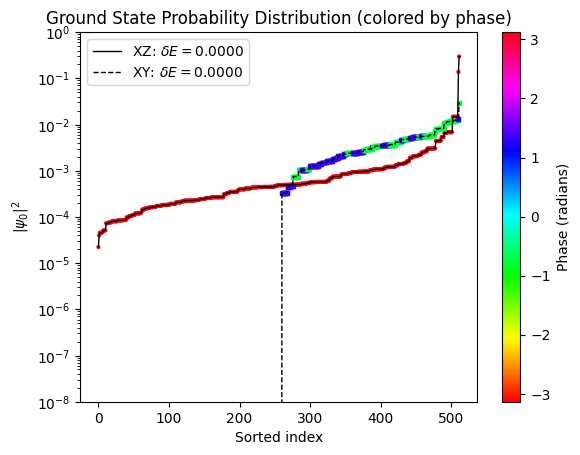

In [22]:
_,_, H_XY = get_XYZ_Hamiltonian(1.0,1.0,0.0, Lx, Ly)
_,_, H_XZ = get_XYZ_Hamiltonian(1.0,0.0,1.0, Lx, Ly)


# E_RBM_XZ = energy_data_xz[-1]
# E_RBM_XY = energy_data_xy[-1]
E_RBM_XZ = 0
E_RBM_XY = 0

energies_XZ, eigenvectors_XZ = nk.exact.lanczos_ed(H_XZ, k = 5, compute_eigenvectors = True)
energies_XY, eigenvectors_XY = nk.exact.lanczos_ed(H_XY, k = 5, compute_eigenvectors = True)
print(energies_XZ)
print(energies_XY)
psi0_XZ = eigenvectors_XZ[:,0]
psi_abs2_XZ = jnp.abs(psi0_XZ)**2
perm_XZ = jnp.argsort(psi_abs2_XZ)

psi0_XY = eigenvectors_XY[:,0]
psi_abs2_XY = jnp.abs(psi0_XY)**2
perm_XY = jnp.argsort(psi_abs2_XY)

plt.scatter(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c=np.angle(psi0_XZ[perm_XZ]), cmap='hsv', s=4)
plt.plot(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c='black', linewidth=1,label = f"XZ: $\delta E= {E_RBM_XZ:.4f}$")

plt.scatter(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c=np.angle(psi0_XY[perm_XY]), cmap='hsv', marker='s', s=8)
plt.plot(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c='black', linewidth=1,linestyle='--',label = f"XY: $\delta E= {E_RBM_XY:.4f}$")
plt.colorbar(label="Phase (radians)")
plt.xlabel("Sorted index")
plt.ylabel(r"$|\psi_0|^2$")
plt.yscale("log")
plt.ylim(1e-8, 1)
plt.legend()
plt.title("Ground State Probability Distribution (colored by phase)")

In [9]:
_,_, H_XY = get_XYZ_Hamiltonian(1.0,1.0,0.0, Lx, Ly)
_,_, H_XZ = get_XYZ_Hamiltonian(1.0,0.0,1.0, Lx, Ly)

energies_XZ, eigenvectors_XZ = nk.exact.lanczos_ed(H_XZ, k = 5, compute_eigenvectors = True)
energies_XY, eigenvectors_XY = nk.exact.lanczos_ed(H_XY, k = 5, compute_eigenvectors = True)

print(energies_XZ)
print(energies_XY)

[-35.99912632 -35.38780838 -35.38780838 -33.57628207 -33.57628207]
[-35.99912632 -35.38780838 -33.57628207 -35.38780838 -33.57628207]
